# CLEAN BUILD FROM SCRATCH EFFNET-UNET b7 on patches

In [1]:
CURRENT_FOLD = 3

# imports

In [2]:
import random

import numpy as np
import pandas as pd
import cv2 as cv
import os

from matplotlib import pyplot as plt
from glob import glob
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import albumentations.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from pathlib import Path
import staintools

In [3]:
from customeunet.utils import *
from customeunet.layers import *
from customeunet.efficientnet import *
from customeunet.efficientunet import *

# model

In [4]:
def AUXhead(in_channels, mid_channels, out_channels, upsample=2):
    return nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.Upsample(scale_factor=upsample, mode='bilinear')
    )

In [5]:
class EfficientUnetAUX(nn.Module):
    def __init__(self, backbone, n_classes=2, concat_input=True):
        super().__init__()
        
        self.backbone = backbone
        
        self.encoder = EfficientNet.encoder(backbone, pretrained=True)
        self.model = EfficientUnet(self.encoder, out_channels=n_classes, concat_input=True)
        
        self.aux1head = AUXhead(512, 512, n_classes, 16)
        self.aux2head = AUXhead(256, 256, n_classes, 8)
        self.aux3head = AUXhead(128, 256, n_classes, 4)
        
        
    def forward(self, x):
        data = self.model(x)
#         for key in data.keys():
#             print(key, data[key].shape)
        aux1 = self.aux1head(data['aux1'])
        aux2 = self.aux2head(data['aux2'])
        aux3 = self.aux3head(data['aux3'])
        out = {
            'logits': data['x'],
            'aux1': aux1,
            'aux2': aux2,
            'aux3': aux3,
        }
        return out

In [6]:
# model = EfficientUnetAUX(backbone='efficientnet-b5', n_classes=6)

In [7]:
# inp = torch.randn(1, 3, 1536, 1536)

In [8]:
# ot = model(inp)

In [9]:
# ot.keys()

# data

In [10]:
ORGAN2ID = {
    'kidney' : 0,
    'prostate' : 1,
    'largeintestine' : 2,
    'spleen' : 3,
    'lung' : 4
}
ID2ORGAN = {v: k for k, v in ORGAN2ID.items()}

## data 512

In [11]:
TRAIN_CSV = './../data/train.csv'
TEST_CSV = './../data/test.csv'
TRAIN_IMAGES_DIR = './../data/train_images_scale_05/'
TRAIN_MASKS_DIR = './../data/train_masks_scale_05/'

N_CROSS_VALID_SPLITS = 5
RANDOM_SEED = 2022

In [12]:
train_df = pd.read_csv(TRAIN_CSV)

In [13]:
def make_train_image_path(row):
    return os.path.join(TRAIN_IMAGES_DIR, str(row['id']) + '.png')

def make_train_mask_path(row):
    return os.path.join(TRAIN_MASKS_DIR, str(row['id']) + '.png')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [14]:
train_df = create_folds(train_df, n_splits=N_CROSS_VALID_SPLITS, random_seed=RANDOM_SEED)

In [15]:
def make_scale05_dataset(df):
    new_df = []
    for index, row in df.iterrows():
        id = row['id']
        glb = list(glob(TRAIN_IMAGES_DIR + '{}.png'.format(id)))
        for fname in glb:
            newrow = dict()
            newrow['id'] = id
            newrow['image'] = fname
            newrow['mask'] = fname.replace('_images_', '_masks_')
            newrow['organ'] = row['organ']
            newrow['pixel_size'] = row['pixel_size']
            newrow['fold'] = row['fold']
            
            new_df.append(newrow)
    return pd.DataFrame(new_df)

In [16]:
train_df_sc05 = make_scale05_dataset(train_df)
print(train_df_sc05.shape)
train_df_sc05.head()

(351, 6)


,fold,id,image,mask,organ,pixel_size
0,4.0,10044,./../data/train_images_scale_05/10044.png,./../data/train_masks_scale_05/10044.png,prostate,0.4
1,0.0,10274,./../data/train_images_scale_05/10274.png,./../data/train_masks_scale_05/10274.png,prostate,0.4
2,0.0,10392,./../data/train_images_scale_05/10392.png,./../data/train_masks_scale_05/10392.png,spleen,0.4
3,0.0,10488,./../data/train_images_scale_05/10488.png,./../data/train_masks_scale_05/10488.png,lung,0.4
4,4.0,10610,./../data/train_images_scale_05/10610.png,./../data/train_masks_scale_05/10610.png,spleen,0.4


In [17]:
# running_mean = np.array([0, 0, 0], dtype=np.float32)
# running_std = np.array([1, 1, 1], dtype=np.float32)

# for fname in tqdm(glob('./../data/train_images_scale_05/*.png')):
#     img = cv.imread(fname)
#     img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
#     img = img.astype(np.float32) / 255.0
    
#     running_mean += img.mean(axis=(0, 1))
#     running_std += img.std(axis=(0, 1))
# #     break
# running_mean = running_mean / 351
# running_std = running_std / 351

In [18]:
# running_mean, running_std

In [19]:
mean = np.array([0.86193335, 0.8364102 , 0.854361  ])
std = np.array([0.16196379, 0.18593247, 0.168352  ])

In [20]:
train_transform1 = A.Compose([
#     A.Resize(512, 512, interpolation=cv.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HueSaturationValue(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=(-0.1, 0.4),rotate_limit=90, p=0.5),
    A.ElasticTransform(p=0.5, alpha=90, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.ElasticTransform(p=0.5, alpha=90, sigma=480 * 0.05, alpha_affine=480 * 0.05),
    A.GridDistortion(p=0.3),
    A.Blur(blur_limit=7, p=0.1),
    A.GaussNoise(var_limit=(20, 120), p=0.2),
#     A.ChannelDropout(p=0.05),
    A.RandomGamma(p=0.05),
    A.RandomBrightnessContrast(p=0.1),
], p=1)

In [21]:
train_transform2 = A.Compose([
    A.Normalize(mean=mean, std=std, 
                max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
])

In [22]:
imaging_measurements = {
    'hpa': {
        'pixel_size': {
            'kidney': 0.4,
            'prostate': 0.4,
            'largeintestine': 0.4,
            'spleen': 0.4,
            'lung': 0.4
        },
        'tissue_thickness': {
            'kidney': 4,
            'prostate': 4,
            'largeintestine': 4,
            'spleen': 4,
            'lung': 4
        }
    },
    'hubmap': {
        'pixel_size': {
            'kidney': 0.5,
            'prostate': 6.263,
            'largeintestine': 0.229,
            'spleen': 0.4945,
            'lung': 0.7562
        },
        'tissue_thickness': {
        'kidney': 10,
            'prostate': 5,
            'largeintestine': 8,
            'spleen': 4,
            'lung': 5
        }
    }
}

In [23]:
def augment_image_stain(image, 
                        domain_pixel_size, 
                        target_pixel_size, 
                        domain_tissue_thickness, 
                        target_tissue_thickness, 
                        alpha=0.15):
    
    """
    Visualize raw and augmented images 
    
    Parameters
    ----------
    image (numpy.ndarray of shape (height, width, 3)): Image array
    domain_pixel_size (float): Pixel size of the domain images in micrometers
    target_pixel_size (float): Pixel size of the target images in micrometers
    domain_tissue_thickness (float): Tissue thickness of the domain images in micrometers
    target_tissue_thickness (float): Tissue thickness of the target images in micrometers
    alpha (float): Multiplier to control saturation and value scale
    """
    image_scaled = image
    
    # Augment tissue thickness
#     tissue_thickness_scale_factor = target_tissue_thickness - domain_tissue_thickness
#     image_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV).astype(np.float32)
#     image_hsv[:, :, 1] *= (1 + (alpha * tissue_thickness_scale_factor))
#     image_hsv[:, :, 2] *= (1 - (alpha * tissue_thickness_scale_factor))
#     image_hsv = image_hsv.astype(np.uint8)
#     image_scaled = cv.cvtColor(image_hsv, cv.COLOR_HSV2RGB)
    
    # Standardize luminosity
    # alredy in data
    # image_scaled = staintools.LuminosityStandardizer.standardize(image_scaled)

    # Augment pixel size
    pixel_size_scale_factor = domain_pixel_size / target_pixel_size
    image_resized = cv.resize(
        image_scaled,
        dsize=None,
        fx=pixel_size_scale_factor,
        fy=pixel_size_scale_factor,
        interpolation=cv.INTER_CUBIC
    )
    image_resized = cv.resize(
        image_resized,
        dsize=(
            image.shape[1],
            image.shape[0]
        ),
        interpolation=cv.INTER_CUBIC
    )
    # already included in 
#     # Standardize luminosity
#     image = staintools.LuminosityStandardizer.standardize(image)
#     image_augmented = staintools.LuminosityStandardizer.standardize(image_resized)
    
    return image, image_resized

In [24]:
def bindice(p=0.5):
    return np.random.uniform() < p

In [25]:
def pad_to(x, stride):
    h, w = x.shape[-2:]

    if h % stride > 0:
        new_h = h + stride - h % stride
    else:
        new_h = h
    if w % stride > 0:
        new_w = w + stride - w % stride
    else:
        new_w = w
    lh, uh = int((new_h-h) / 2), int(new_h-h) - int((new_h-h) / 2)
    lw, uw = int((new_w-w) / 2), int(new_w-w) - int((new_w-w) / 2)
    pads = (lw, uw, lh, uh)

    # zero-padding by default.
    # See others at https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.pad
    out = F.pad(x, pads, "constant", 0)

    return out, pads

def unpad(x, pad):
    if pad[2]+pad[3] > 0:
        x = x[:,:,pad[2]:-pad[3],:]
    if pad[0]+pad[1] > 0:
        x = x[:,:,:,pad[0]:-pad[1]]
    return x

In [26]:
def train_transform(image, mask, organ):
    data = dict()
    data['image'] = image
    data['mask'] = mask
    
#     if bindice(0.5):
#         augm = staintools.StainAugmentor(method='vahadane', sigma1=0.1, sigma2=0.5)
#         augm.fit(data['image'])
#         image_scaled = augm.pop()
# #         print(image_scaled.min(), image_scaled.max(), image_scaled.dtype)
#         data['image'] = np.clip(image_scaled, 0.0, 255.0).astype(np.uint8)
    
    if bindice(0.3):
        _, image = augment_image_stain(data['image'], 
                        domain_pixel_size=0.4, 
                        target_pixel_size=imaging_measurements['hubmap']['pixel_size'][organ],
                        domain_tissue_thickness=4, 
                        target_tissue_thickness=imaging_measurements['hubmap']['tissue_thickness'][organ], 
                        alpha=0.15)
        data['image'] = image
    
    data.update(train_transform1(image=data['image'], mask=data['mask']))
        
    data.update(train_transform2(image=data['image'], mask=data['mask']))
    
    data['image'], _ = pad_to(data['image'], 32)
    data['mask'], _ = pad_to(data['mask'], 32)
    
    return data

In [27]:
val_transform = A.Compose([
#     A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=mean, std=std, 
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [28]:
class HubmapDatasetSc(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        self.length = len(self.df)

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]
        organ = ORGAN2ID[d['organ']]

        image = cv.cvtColor(cv.imread(d['image']), cv.COLOR_BGR2RGB) # .astype(np.float32) / 255.0
        mask = cv.imread(d['mask'], cv.IMREAD_GRAYSCALE)

        mask = mask / max(1, mask.max())
        
        mask_multiclass = mask * (organ + 1)
        
        data = {
            'image': image,
            'mask': mask_multiclass,
            'organ': organ,
        }
        
        upd_data = self.transform(image=data['image'], mask=data['mask'], organ=d['organ'])

        data.update(upd_data)
        return data

In [29]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)
    random.seed(torch_seed + worker_id + 77777)

In [30]:
train_dataset = HubmapDatasetSc(train_df_sc05[train_df_sc05['fold'] != CURRENT_FOLD], train_transform)
val_dataset = HubmapDatasetSc(train_df_sc05[train_df_sc05['fold'] == CURRENT_FOLD], val_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMAGE
torch.Size([3, 1504, 1504])
image values:  -4.522748947143555 0.8798342943191528


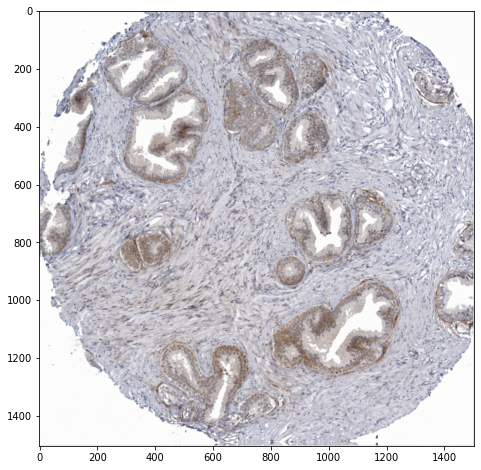

MASK
torch.Size([1504, 1504])
mask values:  tensor(0., dtype=torch.float64) tensor(2., dtype=torch.float64)


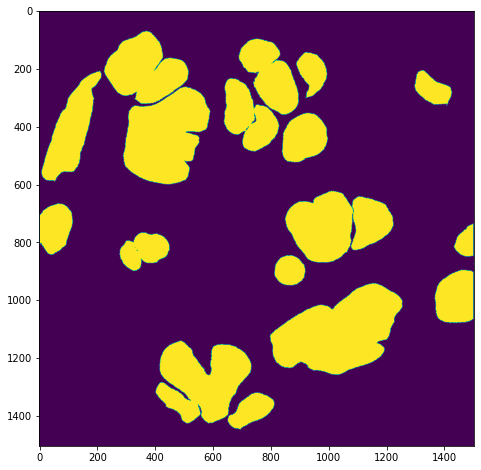

In [31]:
sample = train_dataset[1]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.figure(figsize=(8, 8))
plt.imshow(sample['image'].permute((1, 2, 0)) * std + mean)
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.figure(figsize=(8, 8))
plt.imshow(sample['mask'])
plt.show()

In [32]:
BATCH_SIZE = 1

In [33]:
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          worker_init_fn=worker_init_fn,
                          num_workers=12
                         )
loader_val = DataLoader(val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        worker_init_fn=worker_init_fn,
                        num_workers=0
                       )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMAGE
torch.Size([3, 1434, 1434])
image values:  -4.91015100479126 0.8798342943191528


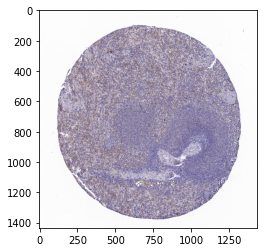

MASK
torch.Size([1434, 1434])
mask values:  tensor(0., dtype=torch.float64) tensor(4., dtype=torch.float64)


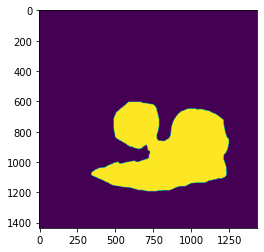

In [34]:
sample = val_dataset[2]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)) * std + mean)
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

# training

In [35]:
!nvidia-smi

Fri Aug 26 00:37:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.152.00   Driver Version: 418.152.00   CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   52C    P0   121W / 300W |  30380MiB / 32478MiB |     69%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   48C    P0    55W / 300W |   1905MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [36]:
device = 'cuda:2'
DEVICE = device

In [37]:
model = EfficientUnetAUX(backbone='efficientnet-b5', n_classes=6).to(device)

In [38]:
model.load_state_dict(torch.load('./checkpoint_fold_3/effnetb5_ep_053_dice_0.103159.pt'))

<All keys matched successfully>

In [39]:
def freeze_m(m):
    for param in m.parameters():
        param.requires_grad = False

In [40]:
def unfreeze_m(m):
    for param in m.parameters():
        param.requires_grad = True

In [41]:
def freeze_top_layers(model):
    freeze_m(model.encoder.stem_conv)
    freeze_m(model.encoder.stem_batch_norm)
    freeze_m(model.encoder.stem_swish)
    for i in range(20):
        freeze_m(model.encoder.blocks[i])

In [42]:
def unfreeze_top_layers(model):
    unfreeze_m(model.encoder.stem_conv)
    unfreeze_m(model.encoder.stem_batch_norm)
    unfreeze_m(model.encoder.stem_swish)
    for i in range(20):
        unfreeze_m(model.encoder.blocks[i])

In [43]:
print('Before Freeze Params:', sum(p.numel() for p in model.parameters() if p.requires_grad))

Before Freeze Params: 43624328


In [44]:
# freeze_top_layers(model)

In [45]:
# print('After Freeze Params:', sum(p.numel() for p in model.parameters() if p.requires_grad))

In [46]:
def lr_function(step):
    start_lr = 1e-5; min_lr = 1e-5; max_lr = 5e-4    #A
    rampup_epochs = 200; sustain_epochs = 200; exp_decay = .99992    #B
 
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs,
           sustain_epochs, exp_decay):
        if epoch < rampup_epochs:    #C
            lr = ((max_lr - start_lr) / rampup_epochs
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:    #D
            lr = max_lr
        else:    #E
            lr = max((max_lr - min_lr) *
                      exp_decay**(epoch - rampup_epochs -
                                    sustain_epochs)* (0.8+0.03*np.sin(epoch / 100)), 0) + min_lr
        return lr
 
    return 1.0#lr(step, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay) / max_lr

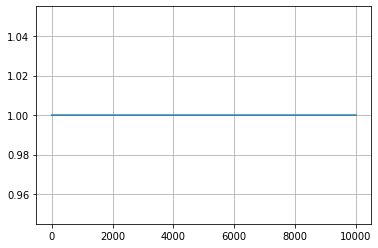

In [47]:
xxx = []
for i in range(10000):
    xxx.append(lr_function(i))
    
plt.plot(xxx)
plt.grid()
plt.show()

# validation code

In [48]:
val_df_id = train_df[train_df['fold'] == CURRENT_FOLD]

In [49]:
import monai
from monai.utils.enums import BlendMode, PytorchPadMode
from monai.inferers import sliding_window_inference

In [50]:
def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union < 1: 
        return 1
    intersection = np.sum(y_true_f * y_pred_f)
#     print('UNION', union)
    return 2. * intersection / union

In [51]:
class Predictor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        out = self.model(x)
        prob = F.softmax(out['logits'], dim=1)
        return prob

In [68]:
def infer_id(predictor, id: str, organ: str, pixel_size=0.4, threshold=0.5):
    THRESHOLD = threshold
    
    image = cv.imread('./../data/train_images_scale_05/{}.png'.format(id))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
#     gt_mask  = np.load('./../data/train_masks_scale_05/{}.png'.format(id))
    gt_mask  = cv.imread('./../data/train_masks_scale_05/{}.png'.format(id), cv.IMREAD_GRAYSCALE)
    
    gt_mask = gt_mask / max(gt_mask.max(), 1)
    
#     scale_factor = 0.5 * (pixel_size / 0.4)
#     image = cv.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_AREA)
    
#     image_rot = image.copy()
    masks = []
    for _ in range(1):
#         image_rot = cv.rotate(image, cv.ROTATE_90_CLOCKWISE)
        
        image_tensor = val_transform(image=image)['image']

        image_tensor = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            infer_result = sliding_window_inference(
                image_tensor, roi_size=(1536, 1536), sw_batch_size=2, predictor=predictor, 
                overlap=0.25, mode=BlendMode.CONSTANT, sigma_scale=0.125, 
                padding_mode=PytorchPadMode.CONSTANT, cval=0.0,       
            )

        organ_id = ORGAN2ID[organ] + 1
        pr_mask = infer_result.detach().cpu().numpy()[0, organ_id]
        masks.append(pr_mask)
        
    pr_mask = (np.array(masks).mean(axis=0) > THRESHOLD).astype(np.uint8)
#     print(gt_mask.shape, gt_mask.dtype, pr_mask.dtype)
    pr_mask = cv.resize(pr_mask, gt_mask.shape, cv.INTER_NEAREST)
    
    return pr_mask, gt_mask

In [69]:
def validate(val_df, model, threshold=0.5):
    predictor = Predictor(model)
    
    dices = []
    
    by_organ_dice = {key:[] for key in ORGAN2ID.keys()}
    for index, row in tqdm(val_df.iterrows(), total=len(val_df)):
        id = row['id']
        organ = row['organ']
        pixel_size = row['pixel_size']
        pred_mask, gt_mask = infer_id(predictor, id, organ=organ, pixel_size=pixel_size, threshold=threshold)
        dice = dice_coef2(gt_mask, pred_mask)
        dices.append(dice)
        by_organ_dice[organ].append(dice)
    new_record = dict()
    new_record['dices'] = dices
    new_record['by_organ'] = by_organ_dice
    return new_record

# losses

In [54]:
import segmentation_models_pytorch as smp

In [55]:
ce_loss = nn.CrossEntropyLoss(label_smoothing=0.05).to(device)

In [56]:
criterion_aux = ce_loss

criterion_tversky = smp.losses.TverskyLoss(
    mode='multiclass', classes=None, log_loss=False, 
    from_logits=True, smooth=0.05, ignore_index=None, 
    eps=1e-07, alpha=0.5, beta=0.5, gamma=1.0
)

def criterion_image(predicts,masks):
    return 0.6 * ce_loss(predicts, masks) + 0.4 * criterion_tversky(predicts, masks)

In [57]:
learning_rate = 2e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)

In [58]:
scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_function)

# training

In [59]:
train_loss = []
accuracy = [] 
lr_hist = []

In [60]:
Path('./checkpoint_fold_{}'.format(CURRENT_FOLD)).mkdir(parents=True, exist_ok=True)

In [61]:
logfile = open('./checkpoint_fold_{}'.format(CURRENT_FOLD) + '/log.train.txt', mode='a')
logfile.write('\n--- [START %s] %s\n\n' % ('effunet-b5', '-' * 64))

90

In [62]:
def log(string):
    print(string)
    logfile.write(string + '\n')

In [63]:
# !mkdir checkpoint_fold_3

In [66]:
N_EPOCHS = 150
# global_it = 0
VIRTUAL_BATCH_SIZE = 24

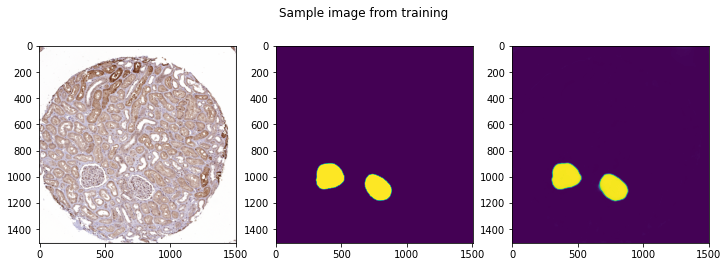

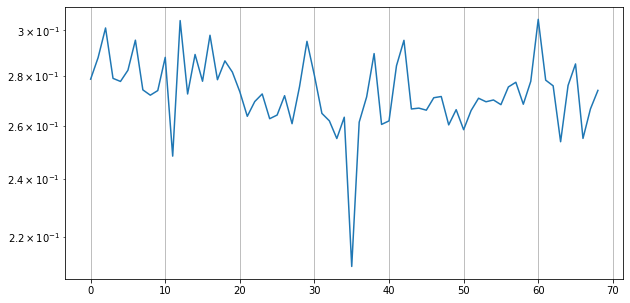

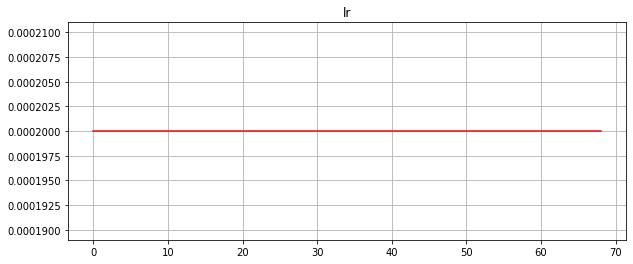

==> Epoch 61 (255/281) | loss: 0.29305


KeyboardInterrupt: 

In [67]:
for epoch in range(58, N_EPOCHS):
    model.train()
    
    batch_train_loss = []
    
    for iteration, batch in enumerate(loader_train):
        global_it += 1
        
        images = batch['image'].to(device, dtype=torch.float)
        masks = batch['mask'].to(device, dtype=torch.long)

        pred = model(images)
        loss_pred = criterion_image(pred['logits'], masks)
        
#         loss_aux1 = criterion_aux(pred['aux1'], masks)
        loss_aux2 = criterion_aux(pred['aux2'], masks)
        loss_aux3 = criterion_aux(pred['aux3'], masks)
        
        loss = 1.0 * loss_pred + 0.02 * loss_aux3 + 0.2 * loss_aux2 #+ 0.2 * loss_aux1
        
        loss.backward()
                 
        batch_train_loss.append(loss.item())
        
        if global_it % VIRTUAL_BATCH_SIZE == 0:
            torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()
        
        if global_it % VIRTUAL_BATCH_SIZE == 0:
            train_loss.append(np.mean(batch_train_loss))
            batch_train_loss = []
            lr_hist.append(optimizer.param_groups[0]['lr'])
            scheduler_warmup.step()
                    
        if global_it % (VIRTUAL_BATCH_SIZE * 1) == 0:
            log('==> Epoch {} ({:03d}/{:03d}) | loss: {:.5f}'.format(epoch, iteration, len(loader_train), loss.item()))

        
            
        if iteration % (VIRTUAL_BATCH_SIZE * 2) == 0:
            clear_output()
            
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
            fig.suptitle('Sample image from training')
            ax1.imshow(np.clip(batch['image'][0].detach().permute((1, 2, 0)).cpu().numpy() * std + mean, 0, 1.0))
            ax2.imshow(batch['mask'].detach().cpu().numpy()[0])
            pred_mask = torch.softmax(pred['logits'].detach(), dim=1)[0, batch['organ'][0].item() + 1]
            ax3.imshow(pred_mask.cpu().numpy(), vmin=0.0, vmax=1.0)
            plt.show()

            plt.figure(figsize=(10, 5))
            plt.yscale('log')
            plt.plot(train_loss)
            plt.grid()
            plt.show()
              
            plt.figure(figsize=(10, 4))
            plt.plot(lr_hist, color='red')
            plt.title('lr')
            plt.grid()
            plt.show()
        
    # val -------------------------------
    if epoch % 1 == 0:
        log('Eval')
        model.eval()

        with torch.no_grad():
            val_res = validate(val_df_id, model)
            val_dice = np.mean(val_res['dices'])
            log('DICE: {}'.format(val_dice))
            for key, value in val_res['by_organ'].items():
                log('{:20}: {:6.5f}'.format(key, np.mean(value)))

            torch.save(model.state_dict(), os.path.join(
                './checkpoint_fold_{}'.format(CURRENT_FOLD), 
                'effnetb5_ep_{:03d}_dice_{:08.6f}.pt'.format(epoch, val_dice)
            )) 
            logfile.flush()

In [ ]:
# optimizer.zero_grad()

In [82]:
model.eval()

with torch.no_grad():
    val_res = validate(val_df_id, model, threshold=0.03)

100%|██████████| 70/70 [00:25<00:00,  2.80it/s]


In [84]:
organ_slc = val_df_id[val_df_id['organ'] == 'lung']

In [86]:
for th in [0.01, 0.02, 0.03, 0.04, 0.05]:
    print(th)
    with torch.no_grad():
        val_res = validate(organ_slc, model, threshold=th)
        val_dice = np.mean(val_res['dices'])
        print('DICE: {}'.format(val_dice))
        for key, value in val_res['by_organ'].items():
            print('{:20}: {:6.5f}'.format(key, np.mean(value)))

0.01


100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


DICE: 0.04967283739030718
kidney              :    nan
prostate            :    nan
largeintestine      :    nan
spleen              :    nan
lung                : 0.04967
0.02


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


DICE: 0.11530888165051496
kidney              :    nan
prostate            :    nan
largeintestine      :    nan
spleen              :    nan
lung                : 0.11531
0.03


100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


DICE: 0.09418991260945997
kidney              :    nan
prostate            :    nan
largeintestine      :    nan
spleen              :    nan
lung                : 0.09419
0.04


100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


DICE: 0.07848030584526873
kidney              :    nan
prostate            :    nan
largeintestine      :    nan
spleen              :    nan
lung                : 0.07848
0.05


100%|██████████| 10/10 [00:03<00:00,  2.77it/s]

DICE: 0.06658756894750671
kidney              :    nan
prostate            :    nan
largeintestine      :    nan
spleen              :    nan
lung                : 0.06659


In [87]:
organ_slc = val_df_id[val_df_id['organ'] == 'prostate']

In [91]:
for th in [0.022, 0.023, 0.024, 0.025]:
    print('-'*40)
    print(th)
    print('-'*40)
    
    with torch.no_grad():
        val_res = validate(organ_slc, model, threshold=th)
        val_dice = np.mean(val_res['dices'])
        print('DICE: {}'.format(val_dice))
        for key, value in val_res['by_organ'].items():
            print('{:20}: {:6.5f}'.format(key, np.mean(value)))

----------------------------------------
0.022
----------------------------------------


100%|██████████| 18/18 [00:06<00:00,  2.85it/s]


DICE: 0.7639731118757198
kidney              :    nan
prostate            : 0.76397
largeintestine      :    nan
spleen              :    nan
lung                :    nan
----------------------------------------
0.023
----------------------------------------


100%|██████████| 18/18 [00:06<00:00,  2.90it/s]


DICE: 0.7645805215670274
kidney              :    nan
prostate            : 0.76458
largeintestine      :    nan
spleen              :    nan
lung                :    nan
----------------------------------------
0.024
----------------------------------------


100%|██████████| 18/18 [00:06<00:00,  2.92it/s]


DICE: 0.7622145069077285
kidney              :    nan
prostate            : 0.76221
largeintestine      :    nan
spleen              :    nan
lung                :    nan
----------------------------------------
0.025
----------------------------------------


100%|██████████| 18/18 [00:06<00:00,  2.90it/s]

DICE: 0.7584149287933738
kidney              :    nan
prostate            : 0.75841
largeintestine      :    nan
spleen              :    nan
lung                :    nan


In [92]:
organ_slc = val_df_id[val_df_id['organ'] == 'spleen']

In [94]:
for th in [0.19, 0.020, 0.021, 0.022]:
    print('-'*40)
    print(th)
    print('-'*40)
    
    with torch.no_grad():
        val_res = validate(organ_slc, model, threshold=th)
        val_dice = np.mean(val_res['dices'])
        print('DICE: {}'.format(val_dice))
        for key, value in val_res['by_organ'].items():
            print('{:20}: {:6.5f}'.format(key, np.mean(value)))

----------------------------------------
0.19
----------------------------------------


100%|██████████| 11/11 [00:03<00:00,  2.76it/s]


DICE: 0.07344888689467445
kidney              :    nan
prostate            :    nan
largeintestine      :    nan
spleen              : 0.07345
lung                :    nan
----------------------------------------
0.02
----------------------------------------


100%|██████████| 11/11 [00:03<00:00,  2.79it/s]


DICE: 0.2479499120216798
kidney              :    nan
prostate            :    nan
largeintestine      :    nan
spleen              : 0.24795
lung                :    nan
----------------------------------------
0.021
----------------------------------------


100%|██████████| 11/11 [00:03<00:00,  2.78it/s]


DICE: 0.24623187174326466
kidney              :    nan
prostate            :    nan
largeintestine      :    nan
spleen              : 0.24623
lung                :    nan
----------------------------------------
0.022
----------------------------------------


100%|██████████| 11/11 [00:04<00:00,  2.73it/s]

DICE: 0.24457046511577588
kidney              :    nan
prostate            :    nan
largeintestine      :    nan
spleen              : 0.24457
lung                :    nan
